<h1>Table of Contents<span class="tocSkip"></span></h1>
[go to](#Samples)


##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fitting Dirichlet Process Mixture Model with Symmetric Dirichlet Prior Using Preconditioned Stochastic Gradient Langevin Dynamics

In this notebook, we will demonstrate how to cluster a large number of samples and infer the number of clusters simultaneously by fitting Dirichlet Process Mixture of Gaussian distribution with Symmetric Dirichlet Prior using Preconditioned Stochastic Gradient Langevin Dynamics (pSGLD). 

## Samples

First, we set up a toy dataset. We generate 50,000 random samples from three bivariate Gaussian distributions.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from progressbar import ProgressBar, Percentage, Bar
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib.patches import Ellipse
from matplotlib import animation, rc
from numpy.linalg import norm
from tqdm import tqdm

tfd = tfp.distributions

In [0]:
# Utility functions from:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb

def session_options(enable_gpu_ram_resizing=True):
    """Convenience function which sets common `tf.Session` options."""
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    return config

def reset_sess(config=None):
    """Convenience function to create the TF graph and session, or reset them."""
    if config is None:
        config = session_options()
    tf.reset_default_graph()
    global sess
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

In [0]:
# For reproducibility
random = np.random.RandomState(seed=45)
tf.set_random_seed(77)

# Precision
dtype = np.float64

# Number of training samples
samples_num = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = random.randint(0, true_components_num, samples_num)
observations = (true_loc[true_hidden_component]
               +random.randn(samples_num, dims).astype(dtype))

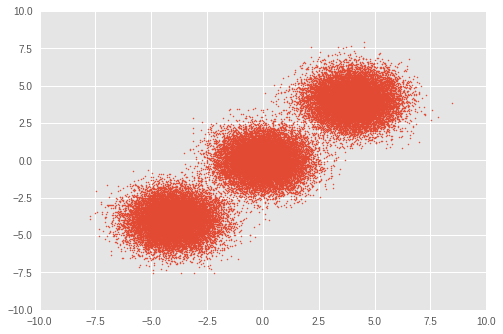

In [5]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1],1)
plt.axis([-10, 10, -10, 10])
plt.show()

## Model

Here, we define a Dirichlet Process Mixture of Gaussian distribution with Symmetric Dirichlet Prior. Throughout the notebook, vector quantities are written in bold. Over  $i\in\{1,\ldots,N\}$ samples, the model with a mixture of $j \in\{1,\ldots,K\}$ Gaussian distributions is formulated as follow:

$$\begin{align*}
p(\boldsymbol{x}_1,\cdots, \boldsymbol{x}_N) &=\prod_{i=1}^N \text{GMM}(x_i), \\
&\,\quad \text{with}\;\text{GMM}(x_i)=\sum_{j=1}^K\pi_j\text{Normal}(x_i\,|\,\text{loc}=\boldsymbol{\mu_{j}},\,\text{scale}=\boldsymbol{\sigma_{j}})\\ 
\end{align*}$$
where:

$$\begin{align*}
x_i&\sim \text{Normal}(\text{loc}=\boldsymbol{\mu}_{z_i},\,\text{scale}=\boldsymbol{\sigma}_{z_i}) \\
z_i &= \text{Categorical}(\text{prob}=\boldsymbol{\pi}),\\
&\,\quad \text{with}\;\boldsymbol{\pi}=\{\pi_1,\cdots,\pi_K\}\\
\boldsymbol{\pi}&\sim\text{Dirichlet}(\text{concentration}=\{\frac{\alpha}{K},\cdots,\frac{\alpha}{K}\})\\
\alpha&\sim \text{InverseGamma}(\text{concentration}=1,\,\text{rate}=1)\\
\boldsymbol{\mu_j} &\sim \text{Normal}(\text{loc}=\boldsymbol{0}, \,\text{scale}=\boldsymbol{1})\\
\boldsymbol{\sigma_j} &\sim \text{InverseGamma}(\text{concentration}=\boldsymbol{1},\,\text{rate}=\boldsymbol{1})\\
\end{align*}$$

Our goal is to assign each $x_i$ to the $j$th cluster through $z_i$ which represents the inferred index of a cluster.

Despite $K$ is set to $\infty$ in an ideal Dirichlet Mixture Model, it is known that one can approximate a Dirichlet Mixture Model with a sufficiently large $K$. Note that although we arbitrarily set an initial value of $K$, an optimal number of clusters is also inferred through optimization,  unlike a simple Gaussian Mixture Model.

In this notebook, we use a bivariate Gaussian distribution as a mixture component and set $K$ to 30.

In [6]:
reset_sess()

# This is K
initial_cluster_num = 30

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.get_variable(
        'mix_probs',
        initializer=np.ones([initial_cluster_num], dtype)/initial_cluster_num))

loc = tf.get_variable(
    'loc',
    initializer=np.zeros([initial_cluster_num, dims], dtype)
               +np.random.uniform(
                   low=-9, #set around minimum value of sample value
                   high=9, #set around maximum value of sample value
                   size=[initial_cluster_num, dims]))

precision = tf.nn.softplus(tf.get_variable(
    'precision',
    initializer=
      np.ones([initial_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.get_variable(
    'alpha',
    initializer=
      np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process. 
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(initial_cluster_num, dtype)*alpha/initial_cluster_num,
    name='rv_sdp')  

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([initial_cluster_num, dims], dtype=dtype),
        scale=tf.ones([initial_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([initial_cluster_num, dims], dtype),
        rate=np.ones([initial_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))

Instructions for updating:
Colocations handled automatically by placer.


## Optimization



We optimize the model with Preconditioned Stochastic Gradient Langevin Dynamics (pSGLD), which enables us to optimize a model over a large number of samples in a mini-batch gradient descent manner. 

To update parameters $\boldsymbol{\theta}\equiv\{\boldsymbol{\pi},\,\alpha,\, \boldsymbol{\mu_j},\,\boldsymbol{\sigma_j}\}$ in $t\,$th iteration with mini-batch size $M$, the gradient $\Delta \boldsymbol { \theta } _ { t }\,$is sampled as:

$$\begin{align*}
\Delta \boldsymbol { \theta } _ { t } & \sim \frac { \epsilon _ { t } } { 2 } \bigl[ G \left( \boldsymbol { \theta } _ { t } \right) \bigl( \nabla _ { \boldsymbol { \theta } } \log p \left( \boldsymbol { \theta } _ { t } \right) \bigr. \bigr. \\
& + \frac { N } { M } \sum _ { k = 1 } ^ { M } \nabla _ \boldsymbol { \theta } \log \text{GMM}(x_{t_k})\bigr) + \sum_\boldsymbol{\theta}\nabla_\theta G \left( \boldsymbol { \theta } _ { t } \right) \bigr]\\
&+ G ^ { \frac { 1 } { 2 } } \left( \boldsymbol { \theta } _ { t } \right) \text { Normal } \left( \text{loc}=\boldsymbol{0} ,\, \text{scale}=\epsilon _ { t }\boldsymbol{1} \right)\\
\end{align*}$$

In the above equation, $\epsilon _ { t }$ is learning rate at $t\,$th iteration and $p(\theta_t)$ is a sum of prior distributions of $\theta$. $G ( \boldsymbol { \theta } _ { t })$ is a preconditioner which adjusts the scale of the gradient of each parameter. 


In [0]:
# Learning rates and decay
starter_learning_rate = 1e-6
end_learning_rate = 1e-10
decay_steps = 1e4

# Number of training steps
training_steps = 10000

# Mini-batch size
batch_size = 20

# Sample size for parameter posteriors
sample_size = 2000

Note that as a consequence of the implementation of pSGLD in Tensorflow Probability optimizes the joint probability of the prior distributions $p(\theta_t)$ and the likelihood $\text{GMM}(x_{t_k})$, the current implementation internally multiplies sample size $N$ to a sum of prior distributions $p(\theta_t)$ as well. To match the equation of pSGLD, we need to divide $p(\theta_t)$ by the sample size when we define the joint probability.

In [0]:
# Placeholder for mini-batch
observations_tensor = tf.placeholder(dtype, shape=[batch_size, dims])

# Define joint log probabilities
# Notice that each prior probability should be divided by samples_num and 
# likelihood is divided by batch_size for pSGLD optimization. 
log_prob_parts = [
    rv_loc.log_prob(loc)/samples_num,
    rv_precision.log_prob(precision)/samples_num,
    rv_alpha.log_prob(alpha)/samples_num,
    rv_symmetric_dirichlet_process.log_prob(mix_probs)[..., tf.newaxis]/samples_num,
    rv_observations.log_prob(observations_tensor)/batch_size
]
joint_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)

In [11]:
# Make mini-batch generator
dx = tf.data.Dataset.from_tensor_slices(observations).shuffle(500).repeat().batch(batch_size)
iterator = dx.make_one_shot_iterator()
next_batch = iterator.get_next()

# Define learning rate scheduling
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate,
    global_step, decay_steps,
    end_learning_rate, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
    learning_rate=learning_rate,
    preconditioner_decay_rate=0.99,
    burnin=1500,
    data_size=samples_num)

train_op = optimizer_kernel.minimize(-joint_log_prob)

# Arrays to store samples
mean_mix_probs_mtx = np.zeros([training_steps, initial_cluster_num])
mean_alpha_mtx = np.zeros([training_steps, 1])
mean_loc_mtx = np.zeros([training_steps, initial_cluster_num, dims])
mean_precision_mtx = np.zeros([training_steps, initial_cluster_num, dims])

init = tf.global_variables_initializer()
sess.run(init)

for it in tqdm(range(training_steps)):
    [ 
        mean_mix_probs_mtx[it, :],
        mean_alpha_mtx[it, 0],
        mean_loc_mtx[it, :, :],
        mean_precision_mtx[it, :, :],   
      _
    ] = sess.run([
        *training_vals,
        train_op
    ], feed_dict={
        observations_tensor: sess.run(next_batch),
    })

# Take mean over the last sample_size iterations
mean_mix_probs_ = mean_mix_probs_mtx[-sample_size:,:].mean(axis=0)
mean_alpha_ = mean_alpha_mtx[-sample_size:,:].mean(axis=0)
mean_loc_ = mean_loc_mtx[-sample_size:,:].mean(axis=0)
mean_precision_ = mean_precision_mtx[-sample_size:,:].mean(axis=0)

Instructions for updating:
Use tf.cast instead.


100%|██████████| 10000/10000 [05:46<00:00, 28.89it/s]


## Visualize the result

### Clustered result

First, we visualize the result of clustering.


For assigning each sample $x_i$ to a cluster $j$, we calculate the posterior of $z_i$ as:

$$\begin{align*}
\DeclareMathOperator*{\argmax}{arg\,max} %argmax
j = \argmax_{z_i}\,p(z_i\,|\,x_i,\,\boldsymbol{\theta})
\end{align*}$$

Number of estimated clusters = 3

Number of elements in each = [16453 16627 16920]



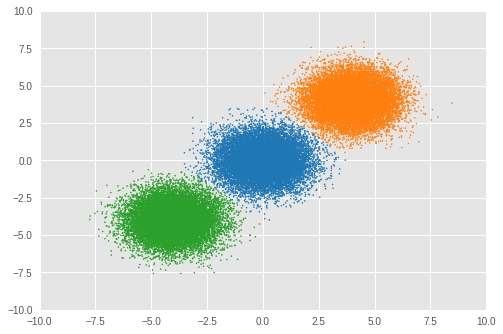

In [19]:
# Posterior of z
loc_for_posterior = tf.placeholder(dtype, [initial_cluster_num, dims], name="loc_for_posterior")
precision_for_posterior = tf.placeholder(dtype, [initial_cluster_num, dims], name="precision_for_posterior")
mix_probs_for_posterior = tf.placeholder(dtype, [initial_cluster_num], name="mix_probs_for_posterior")

unnomarlized_posterior_of_z = tfd.MultivariateNormalDiag(loc=loc_for_posterior, scale_diag=precision_for_posterior).log_prob(tf.expand_dims(observations, axis=1))\
                               +tf.log(mix_probs_for_posterior[tf.newaxis,...])
result = sess.run(tf.argmax(unnomarlized_posterior_of_z, axis=1), feed_dict={
    loc_for_posterior: mean_loc_,
    precision_for_posterior: mean_precision_,
    mix_probs_for_posterior: mean_mix_probs_
})
idxs, count = np.unique(result, return_counts=True)

print("Number of inferred clusters = {}\n".format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("Number of elements in each cluster = {}\n".format(count))

def convert_int_elements_to_consecutive_numbers_in(array):
    unique_int_elements = np.unique(array)
    for consecutive_number, unique_int_element in enumerate(unique_int_elements):
        array[array==unique_int_element] = consecutive_number
    return array

cmap = plt.get_cmap("tab10")
plt.scatter(observations[:, 0], observations[:, 1],1, c=cmap(convert_int_elements_to_consecutive_numbers_in(result)))
plt.axis([-10, 10, -10, 10])
plt.show()


We can see an almost equal number of samples are assigned to appropriate clusters and the model has correctly inferred the correct number of clusters as well.


### Mean and scale of selected mixture component

Next, we look at selected clusters' $\mu_j$ and $\sigma_j$.

In [20]:
for idx, numbe_of_samples in zip(idxs, count):
    print("Component id = {}, Number of elements = {}".format(idx, numbe_of_samples))
    print("Mean loc = {}, Mean scale = {}\n".format(mean_loc_[idx, :], mean_precision_[idx, :]))

Component id = 5, Number of elements = 16453
Mean loc = [ 0.011 -0.006], Mean scale = [ 1.009  1.004]

Component id = 6, Number of elements = 16627
Mean loc = [ 4.013  4.028], Mean scale = [ 0.999  1.007]

Component id = 19, Number of elements = 16920
Mean loc = [-4.014 -4.013], Mean scale = [ 0.995  0.996]



Again, the model inferred  $\mu_j$ and $\sigma_j$ close to the ground truth.

### Mixture weight of each mixture component

We also look at inferred mixture weights.

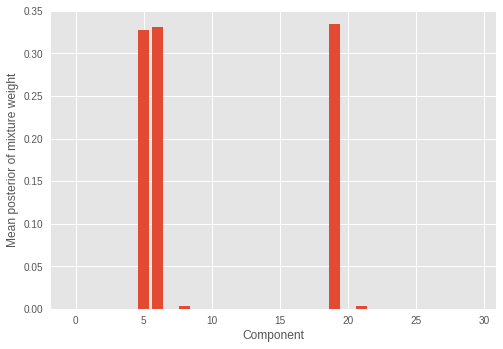

In [23]:
plt.ylabel("Mean posterior of mixture weight")
plt.xlabel("Component")
plt.bar(range(0, initial_cluster_num),mean_mix_probs_)
plt.show()

We see only a few (three) mixture component have significant weights and the rest of the weights have values close to zero. This also shows the model successfully inferred the correct number of mixture components which constitutes the distribution of the samples.

### Convergence of $\alpha$

We look at convergence of Dirichlet distribution's concentration parameter $\alpha$.

Value of inferred alpha = 0.968



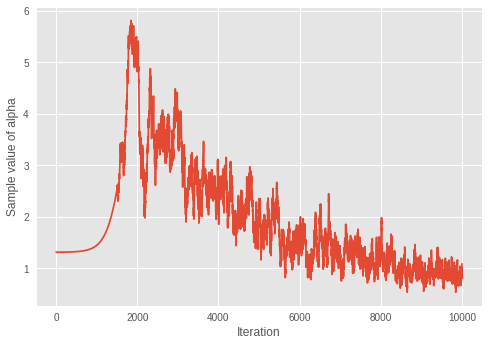

In [28]:
print("Value of inferred alpha = {0:.3f}\n".format(mean_alpha_[0]))
plt.ylabel("Sample value of alpha")
plt.xlabel("Iteration")
plt.plot(mean_alpha_mtx)
plt.show()

Considering the fact that smaller $\alpha$ results in less expected number of clusters in a Dirichlet mixture model, the model seems to be learning the optimal number of clusters over iterations.

### Inferred number of clusters over iterations

We visualize how the inferred number of clusters changes over iterations.

To do so, we infer the number of clusters over the iterations.

In [25]:
step = sample_size
num_of_iterations = 100
estimated_num_of_clusters = []
interval = (training_steps - step)//(num_of_iterations-1)
iterations = np.asarray(range(step, training_steps+1, interval))

for iteration in tqdm(iterations):
    start_position = iteration-step
    end_position = iteration
    
    result = sess.run(tf.argmax(unnomarlized_posterior_of_z, axis=1), feed_dict={
      loc_for_posterior: mean_loc_mtx[start_position:end_position, :].mean(axis=0),
      precision_for_posterior: mean_precision_mtx[start_position:end_position, :].mean(axis=0),
      mix_probs_for_posterior: mean_mix_probs_mtx[start_position:end_position, :].mean(axis=0)
    })
    
    idxs, count = np.unique(result, return_counts=True)
    estimated_num_of_clusters.append(len(count))                                                                                                                        

100%|██████████| 101/101 [00:19<00:00,  5.01it/s]


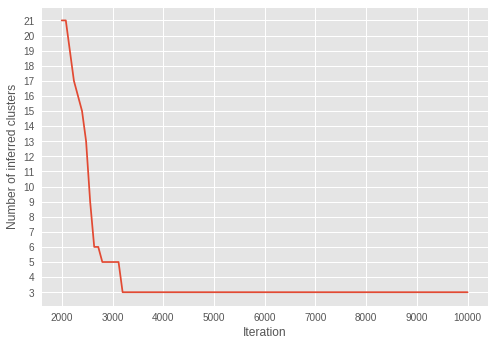

In [26]:
plt.ylabel("Number of inferred clusters")
plt.xlabel("Iteration")
plt.yticks(np.arange(1, max(estimated_num_of_clusters)+1, 1))
plt.plot(iterations-1, estimated_num_of_clusters)
plt.show()

Over the iterations, the number of clusters is getting closer to three. With the result of convergence of $\alpha$ to smaller value over iterations, we can see the model is successfully learning the parameters to infer an optimal number of clusters.

Interestingly, we can see the inference has already converged to the correct number of clusters in the early iterations, unlike $\alpha$ converged in much later iterations. 


## Conclusion

In this notebook, we described how to cluster a large number of samples as well as to infer the number of clusters simultaneously by fitting Dirichlet Process Mixture of Gaussian distribution with Symmetric Dirichlet Prior using Preconditioned Stochastic Gradient Langevin Dynamics (pSGLD).

The experiment shows the model successfully clustered samples and inferred a correct number of clusters. Also, the model could infer the correct parameters of mixture components which were reasonably close to the ground truth. Lastly by visualizing the correlation between convergence of 𝛼 and the number of inferred clusters, we could see how the model is learning the parameter to control the number of effective clusters.

Although the toy dataset only had 50,000 samples with only two dimensions, the mini-batch manner optimization used here is scalable for much larger datasets.